In [1]:
%matplotlib notebook
import numpy as np
from proj1_helpers import load_csv_data, create_csv_submission
from helpers import *
import matplotlib.pyplot as plt

cheminTrain = 'C:/Users/Raphael/Desktop/EPFL/Machine_Learning/train.csv'
cheminTest =  'C:/Users/Raphael/Desktop/EPFL/Machine_Learning/test.csv'
def compute_mse(y, tx, w):
    return (1/(2*tx.shape[0]))*np.linalg.norm(y-tx@w)**2
def compute_loss_rmse(y,tx,w):
    return (compute_mse(y,tx,w)*2)**0.5
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x
def standardizeNine(x):
    mask = np.any( x == -999, axis=0)
    xWithnine = np.copy(x)
    columnStandardize = (x[:,mask] == -999).astype(int)
    xWithnine[:,mask] = columnStandardize
    return xWithnine
def addColumnNine(x):
    mask = np.any( x == -999, axis=0)
    columnStandardize = (x[:,mask] == -999).astype(int)
    return columnStandardize
    
def standardizeNineByMean(x):
    mask = np.any( x == -999, axis=0)
    print(mask.shape)
    xWithnine = np.copy(x)
    df3 = xWithnine[:,mask]
    for i in range(mask.shape[0]):
        test = df3[:,i]
        test2 = test[test !=-999]
        mean = np.mean(test2)     
        df3[:,i][np.where(test == -999)] = mean
    return df3
    
def build_k_indices(y, k_fold, seed):
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1
    return y_pred

In [2]:
def ridge_regression(y, tx, lambda_):
    txt = tx.transpose()
    lambda_prim = 2*y.shape[0]*lambda_
    identity = np.identity(tx.shape[1])
    w = np.linalg.inv(txt@tx+lambda_prim*identity)@txt@y
    #w= np.linalg.solve(txt@tx+lambda_prim*identity,txt@y)
    loss = compute_mse(y,tx,w)
    return loss,w

In [3]:
def cross_validation_visualization(lambds, mse_tr, mse_te):

    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation (k_fold = 5): Ridge regression")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

# IMPORT DATA

In [4]:
# load data.
yb, input_data, ids = load_csv_data(cheminTrain)
yb_test, input_data_test, ids_test = load_csv_data(cheminTest)


print(input_data)



[[ 138.47    51.655   97.827 ...,    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ..., -999.    -999.      46.226]
 [-999.     162.172  125.953 ..., -999.    -999.      44.251]
 ..., 
 [ 105.457   60.526   75.839 ..., -999.    -999.      41.992]
 [  94.951   19.362   68.812 ..., -999.    -999.       0.   ]
 [-999.      72.756   70.831 ..., -999.    -999.       0.   ]]


# Preprocess

In [23]:
#withoutNine = standardizeNine(input_data)
print(input_data.shape)
print(input_data_test.shape)
#whitoutNine_test = standardizeNine(input_data_test)
x,_,_ = standardize(input_data)
x_test,_,_ = standardize(input_data_test)
x_NineColumn = addColumnNine(input_data)
x_test_NineColumn = addColumnNine(input_data_test)

y = (yb + 1) / 2

(250000, 30)
(568238, 30)


In [6]:
def cross_validation(y, x, k_indices, k, lambda_, degree):

    testLine = k_indices[k]
    k_indices_prim = np.delete(k_indices,k,0).flatten()
    testX = x[testLine]
    testY = y[testLine]
    trainX = x[k_indices_prim]
    trainY = y[k_indices_prim]
    
    traintmpX = build_poly(trainX,degree)
    testmpX = build_poly(testX,degree)
    
    
    loss, w = ridge_regression(trainY,traintmpX,lambda_)
    loss_tr = loss
    loss_te = compute_mse(testY,testmpX,w)
    
    y_predTest = predict_labels(w, testmpX)
    print(len(y_predTest[y_predTest == -1]) / len(y_predTest))
    
    return w, loss_tr, loss_te

In [7]:
def build_poly(x, degree):
    y = np.copy(x)
    for i in range(1,degree):
        y = np.concatenate((y,np.power(x,i+1)),axis=1)
                           
    return y

In [8]:
a = np.array([[1,2,3],[2,2,2]])
build_poly(a,2)
b = np.array([[-999,2,3],[-999,2,2],[3,4,-999]])

#kk = standardizeNineByMean(b)
#print(kk)

#mask = np.any( b == -999, axis=0)
#print(mask)
#df3 = b[:,mask]
#print(df3)
#test = df3[:,0]
#test2 = test[test !=-999]
#mean = np.mean(test2)
#print('\n')
#print('\n')
#print(test)
#print(mean)

#print(test)
#test[np.where(test == -999)] = mean
#print(test)


    #test = df3[:,i]
    #test = test[test != -999]
    #mean = np.mean(test)
    #print(np.mean(test))
    #print(test)
    #iiii = df3[df3[:,i] == -999] = mean
    #print(iiii)
    #res = np.concatenate((res,test[tes]))
#print(df3)
#print(df3)
#columnStandardize = (x[:,mask] == -999).astype(int)
#xWithnine[:,mask] = columnStandardize

In [9]:

def cross_validation_demo():
    seed = 1
    degree = 2
    k_fold = 5
    xxxxxx = build_poly(x,degree)
    xxxxxx = np.concatenate((xxxxxx,x_NineColumn),axis = 1)
    xxxxxx = np.concatenate((np.ones((xxxxxx.shape[0],1)),xxxxxx),axis=1)
    lambdas = np.logspace(-12, 5, 5)
    
    k_indices = build_k_indices(y, k_fold, seed)
    
    rmse_tr = []
    rmse_te = []

    for ind, lambda_ in enumerate(lambdas):
        loss_tr_total = 0;
        loss_te_total = 0;
        for k in range(k_fold) :
            w,loss_tr,loss_te = cross_validation(y, xxxxxx, k_indices, k, lambda_, degree)
            loss_tr_total += loss_tr
            loss_te_total += loss_te

        rmse_tr.append(loss_tr_total/k_fold)
        rmse_te.append(loss_te_total/k_fold)
        print("Current lambda = {i}".format(i=lambda_))

    print(rmse_tr)
    print(rmse_te)
    #cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [10]:

cross_validation_demo()

0.15784
0.9797
0.91088
0.15194
0.3018
Current lambda = 1e-12
0.71612
0.71872
0.7142
0.71774
0.71564
Current lambda = 1.7782794100389228e-08
0.7205
0.7231
0.7167
0.7199
0.71998
Current lambda = 0.00031622776601683794
0.94402
0.94288
0.94538
0.94394
0.9446
Current lambda = 5.623413251903491
0.9999
0.99982
0.99972
0.99998
0.9999
Current lambda = 100000.0
[7.6852227930334056, 0.077879092002636346, 0.079790691806010589, 0.10037402373015288, 0.17090744579698638]
[183.68463028083374, 168.26613176951872, 172.83014288202281, 39.941273500789784, 27.788605317061467]


In [11]:
lambda_ = 0.00001
degree = 4
#traintmpX = build_poly(x[:,0:3],degree)
#testmpX = build_poly(x_test[:,0:3],degree)
traintmpX = build_poly(x,degree)
testmpX = build_poly(x_test,degree)
traintmpXX = np.concatenate((traintmpX,x_NineColumn),axis = 1)
testmpXX = np.concatenate((testmpX,x_test_NineColumn),axis = 1)
print(y.shape)
print(traintmpX.shape)
print(traintmpXX.shape)
loss, w = ridge_regression(y,traintmpXX,lambda_)
y_pred = predict_labels(w, testmpXX)
create_csv_submission(ids_test, y_pred, 'submission_for_kaggle.csv')

(250000,)
(250000, 120)
(250000, 131)


In [12]:
len(y_pred[y_pred == -1]) / len(y_pred)

0.740158173159838

In [13]:
len(yb[yb == -1]) / len(yb)

0.657332

In [14]:
y_pred.shape

(568238,)

In [15]:
def split_data(x, y, ratio, seed=1):

    np.random.seed(seed)
    N = len(x)

    n_train = int(ratio * N)
    
    train_index = np.random.choice(N, n_train, replace=False)

    index = np.arange(N)

    mask = np.in1d(index, train_index)

    test_index = np.random.permutation(index[~mask])

    x_train = x[train_index]
    y_train = y[train_index]

    x_test = x[test_index]
    y_test = y[test_index]

    return x_train, y_train, x_test, y_test

def prediction(w_train,tx,y_test):
    
    y_pred1 = predict_labels(w_train,tx)

    for n,i in enumerate(y_test):
        if i==0:
              y_test[n]=-1
            
    right = 0
    wrong = 0

    for i in range(len(y_test)):
        if y_test[i] == y_pred1[i]:
            right +=1 
        else:
            wrong +=1 
    
        
    print("Good prediction : ", right)
    print("Bad predition : " , wrong)
    print("Ratio : " ,right/len(y_test))
    return right/len(y_test)

(568238,)
Good prediction :  39532
Bad predition :  10468
Ratio :  0.79064
Current lambda = 1e-14
Good prediction :  39708
Bad predition :  10292
Ratio :  0.79416
Current lambda = 1.8873918221350994e-14
Good prediction :  39713
Bad predition :  10287
Ratio :  0.79426
Current lambda = 3.5622478902624366e-14
Good prediction :  39701
Bad predition :  10299
Ratio :  0.79402
Current lambda = 6.723357536499335e-14
Good prediction :  39710
Bad predition :  10290
Ratio :  0.7942
Current lambda = 1.2689610031679234e-13
Good prediction :  39723
Bad predition :  10277
Ratio :  0.79446
Current lambda = 2.395026619987491e-13
Good prediction :  39716
Bad predition :  10284
Ratio :  0.79432
Current lambda = 4.5203536563602407e-13
Good prediction :  39709
Bad predition :  10291
Ratio :  0.79418
Current lambda = 8.531678524172814e-13
Good prediction :  39708
Bad predition :  10292
Ratio :  0.79416
Current lambda = 1.6102620275609425e-12
Good prediction :  39705
Bad predition :  10295
Ratio :  0.7941
Cu

<IPython.core.display.Javascript object>


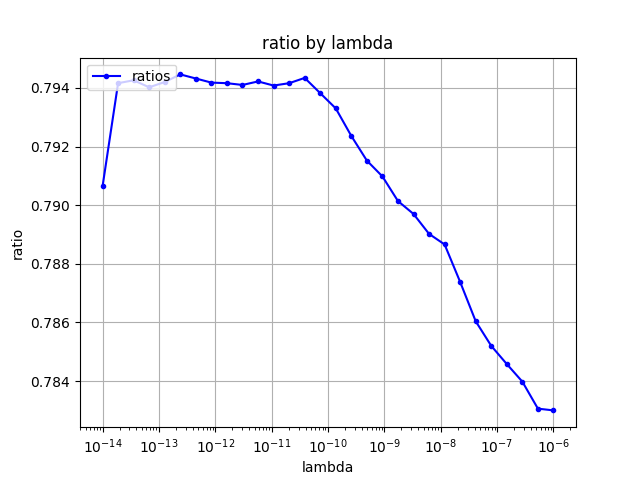

In [24]:
x_NineColumn = addColumnNine(input_data)
x_test_NineColumn = addColumnNine(input_data_test)

lambda_x = 1e-13
lambdas = np.logspace(-14, -6, 30)
degree = 4

x_wout_categ = np.delete(x,[22],axis = 1)
x_test_wout_categ = np.delete(x_test,[22],axis = 1)
x_wout_categ = np.concatenate((np.ones((c.shape[0],1)),x_wout_categ),axis=1)
x_test_wout_categ = np.concatenate((np.ones((d.shape[0],1)),x_test_wout_categ),axis=1)

a = build_poly(x_wout_categ,degree)
b = build_poly(x_test_wout_categ,degree)
c = np.concatenate((a,x_NineColumn),axis = 1)
d = np.concatenate((b,x_test_NineColumn),axis = 1)

#c = np.concatenate((np.ones((c.shape[0],1)),c),axis=1)
#d = np.concatenate((np.ones((d.shape[0],1)),d),axis=1)

#loss, w = ridge_regression(y,c,lambda_)
#y_pred = predict_labels(w, d)
print(y_pred.shape)
#create_csv_submission(ids_test, y_pred, 'submission_for_kaggle.csv')

x_train, y_train, x_test, y_test = split_data(c, y, 0.8)
ratios = []

for ind, lambda_ in enumerate(lambdas):
    loss, w = ridge_regression(y_train,x_train,lambda_)
    ratios.append(prediction(w,x_test,y_test))
    print("Current lambda = {i}".format(i=lambda_))

ratio_visualization(lambdas, ratios)




In [17]:
def ratio_visualization(lambds, ratios):

    plt.clf()
    plt.semilogx(lambds, ratios, marker=".", color='b', label='ratios')
    plt.xlabel("lambda")
    plt.ylabel("ratio")
    plt.title("ratio by lambda")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()
    plt.savefig("ratios by lambda")

In [18]:
print(y_pred.shape)

(568238,)


In [ ]:
ratios_deg = []
for deg in range(1,9):
    a = build_poly(x_wout_categ,deg)
    b = build_poly(x_test_wout_categ,deg)
    c = np.concatenate((a,x_NineColumn),axis = 1)
    d = np.concatenate((b,x_test_NineColumn),axis = 1)
    x_train, y_train, x_test, y_test = split_data(c, y, 0.8)
    loss, w = ridge_regression(y_train,x_train,lambda_)
    ratios_deg.append(prediction(w,x_test,y_test))
    print("Current degrees = {i}".format(i=deg))

ratio_visualization(range(1,9),ratios_deg)

Good prediction :  37208
Bad predition :  12792
Ratio :  0.74416
Current degrees = 1
Good prediction :  38384
Bad predition :  11616
Ratio :  0.76768
Current degrees = 2
Good prediction :  38837
Bad predition :  11163
Ratio :  0.77674
Current degrees = 3
Good prediction :  39150
Bad predition :  10850
Ratio :  0.783
Current degrees = 4
Good prediction :  39536
Bad predition :  10464
Ratio :  0.79072
Current degrees = 5
Good prediction :  39700
Bad predition :  10300
Ratio :  0.794
Current degrees = 6
Good prediction :  39772
Bad predition :  10228
Ratio :  0.79544
Current degrees = 7


In [25]:
def degree_visualization(degrees, ratios):

    plt.clf()
    plt.semilogx(degrees, ratios, marker=".", color='b', label='ratios')
    plt.xlabel("degree")
    plt.ylabel("ratio")
    plt.title("ratio by degree")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()
    plt.savefig("ratios by degrees")